Plot saved to figures/repressilator_deterministic_plot.png


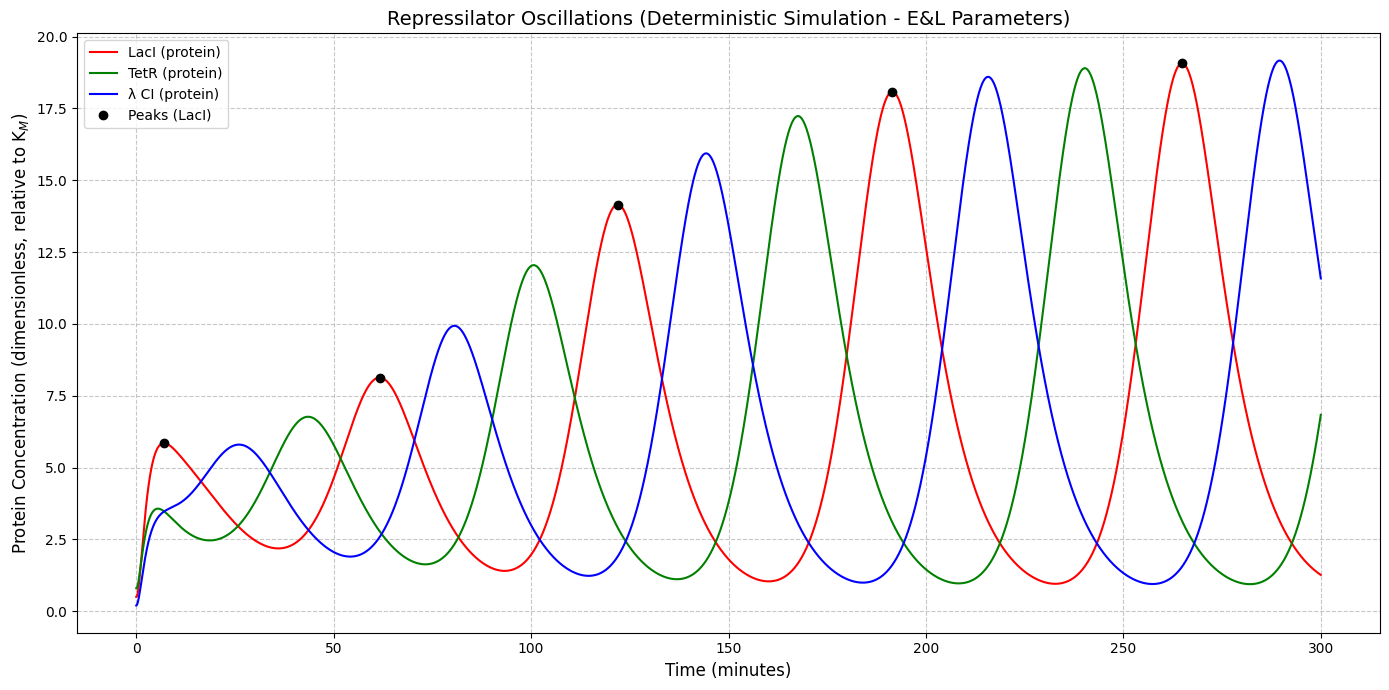


--- Oscillation Analysis (LacI) ---
Period: 64.46 ± 7.44 minutes (based on 4 cycles)
Amplitude: Min Peak=5.85, Max Peak=19.07, Mean Peak=13.06


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import os # Import the os module to check for directory existence

# Repressilator system of Ordinary Differential Equations (ODEs)
# This model describes the concentrations of 3 mRNAs and their corresponding proteins.
def repressilator_ode(t, y, alpha, alpha_0, beta, n):
    m1, p1, m2, p2, m3, p3 = y # m_i are mRNAs, p_i are proteins

    # Rate of change for LacI mRNA (m1), repressed by CI protein (p3)
    dm1_dt = -m1 + alpha / (1 + p3**n) + alpha_0
    # Rate of change for LacI protein (p1)
    dp1_dt = -beta * (p1 - m1)

    # Rate of change for TetR mRNA (m2), repressed by LacI protein (p1)
    dm2_dt = -m2 + alpha / (1 + p1**n) + alpha_0
    # Rate of change for TetR protein (p2)
    dp2_dt = -beta * (p2 - m2)

    # Rate of change for CI mRNA (m3), repressed by TetR protein (p2)
    dm3_dt = -m3 + alpha / (1 + p2**n) + alpha_0
    # Rate of change for CI protein (p3)
    dp3_dt = -beta * (p3 - m3)

    return [dm1_dt, dp1_dt, dm2_dt, dp2_dt, dm3_dt, dp3_dt]

# --- Parameters for the simulation ---
# These are based on Elowitz & Leibler (2000), Nature, Box 1 and Fig 1c context.

# Ratio of protein degradation rate to mRNA degradation rate.
# Derived from: protein half-life ~10 min, mRNA half-life ~2 min.
# beta = (ln(2)/10 min) / (ln(2)/2 min)
beta = 0.2

# Hill coefficient: describes the steepness of repression. n=2 indicates cooperative binding.
n = 2

# Dimensionless maximum transcription rate (how fast mRNA is made when not repressed).
# This value affects the amplitude of oscillations.
alpha = 50

# Dimensionless basal (leaky) transcription rate (small amount of mRNA made even when repressed).
# Set as 1/1000th of alpha, based on paper's Figure 1c caption.
alpha_0 = alpha * 0.001

# --- Initial conditions for the simulation ---
# [mLacI, pLacI, mTetR, pTetR, mCI, pCI]
# These are dimensionless concentrations (protein conc. relative to K_M).
# Asymmetric conditions help to initiate oscillations.
y0 = [0.1, 0.5, 0.2, 0.8, 0.3, 0.2]

# --- Time span for the simulation ---
# We simulate for enough dimensionless time to see several oscillation cycles.
# With beta=0.2, the period is longer.
t_final_dimensionless = 150
# Generate evenly spaced time points for the solver to evaluate the solution.
t_eval_dimensionless = np.linspace(0, t_final_dimensionless, 4000)

# --- Solve the system of ODEs ---
# solve_ivp integrates the system of ODEs.
# 'RK45' is a standard, robust method for solving ODEs.
# rtol and atol are relative and absolute error tolerances for the solver.
solution = solve_ivp(
    repressilator_ode,
    (t_eval_dimensionless[0], t_eval_dimensionless[-1]),
    y0,
    args=(alpha, alpha_0, beta, n),
    t_eval=t_eval_dimensionless,
    method='RK45',
    rtol=1e-6,
    atol=1e-9
)

# --- Convert dimensionless time to minutes for plotting ---
# Based on Box 1: "Time is rescaled in units of the mRNA lifetime."
# For visualization, we often use the mRNA half-life (2 min from paper) as this scaling factor.
time_minutes = solution.t * 2

# --- Plotting the protein oscillations ---
plt.figure(figsize=(14, 7))
plt.plot(time_minutes, solution.y[1], 'r-', label='LacI (protein)')  # p1 is at index 1
plt.plot(time_minutes, solution.y[3], 'g-', label='TetR (protein)')  # p2 is at index 3
plt.plot(time_minutes, solution.y[5], 'b-', label='λ CI (protein)') # p3 is at index 5

# --- Detect and mark peaks for LacI to estimate period ---
# `find_peaks` helps identify the tops of the waves.
# `prominence` ensures we only get significant peaks.
# `distance` sets a minimum separation between peaks.
peaks_indices, _ = find_peaks(solution.y[1], prominence=1, distance=int(20 / (2* (t_eval_dimensionless[1]-t_eval_dimensionless[0])) ) ) # min distance ~20 mins
plt.plot(time_minutes[peaks_indices], solution.y[1][peaks_indices], 'ko', label='Peaks (LacI)')

# --- Styling the plot ---
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Protein Concentration (dimensionless, relative to K$_M$)', fontsize=12) # K_M for subscript
plt.title('Repressilator Oscillations (Deterministic Simulation - E&L Parameters)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping

# --- ADD THIS SECTION TO SAVE THE FIGURE ---
FIGURES_DIR = 'figures' # Define a variable for the directory name
# Create the 'figures' directory if it doesn't already exist
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)

# Save the plot to the 'figures' directory
plot_filename = os.path.join(FIGURES_DIR, 'repressilator_deterministic_plot.png')
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
print(f"Plot saved to {plot_filename}")
# --- END OF SAVE FIGURE SECTION ---

plt.show() # Display the plot

# --- Calculate and print the oscillation period and amplitude stats ---
if len(peaks_indices) > 1:
    periods = np.diff(time_minutes[peaks_indices])
    mean_period = np.mean(periods)
    std_period = np.std(periods)
    print(f"\n--- Oscillation Analysis (LacI) ---")
    print(f"Period: {mean_period:.2f} ± {std_period:.2f} minutes (based on {len(periods)} cycles)")

    peak_amplitudes = solution.y[1][peaks_indices]
    print(f"Amplitude: Min Peak={np.min(peak_amplitudes):.2f}, Max Peak={np.max(peak_amplitudes):.2f}, Mean Peak={np.mean(peak_amplitudes):.2f}")
else:
    print("\nFewer than 2 peaks detected for LacI. Oscillation analysis might be unreliable.")
    print("Consider increasing simulation time, or adjusting 'prominence' and 'distance' in find_peaks.")